In [1]:
import sys
sys.path

['D:\\Anaconda\\envs\\position_completion_new\\python36.zip',
 'D:\\Anaconda\\envs\\position_completion_new\\DLLs',
 'D:\\Anaconda\\envs\\position_completion_new\\lib',
 'D:\\Anaconda\\envs\\position_completion_new',
 '',
 'D:\\Anaconda\\envs\\position_completion_new\\Lib\\site-packages',
 'D:\\Anaconda\\envs\\position_completion_new\\Lib\\site-packages\\win32',
 'D:\\Anaconda\\envs\\position_completion_new\\Lib\\site-packages\\win32\\lib',
 'D:\\Anaconda\\envs\\position_completion_new\\Lib\\site-packages\\Pythonwin',
 'D:\\Anaconda\\envs\\position_completion_new\\Lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\93973\\.ipython']

In [2]:
print(sys.version)
print(sys.executable)

3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
D:\Anaconda\envs\position_completion_new\python.exe


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [4]:
import os 
os.chdir("../")

In [5]:
# 用营业收入ttm环比增长率当作因子做单因子策略
matplotlib.rcParams['font.sans-serif']=['Times New Roman'] 

#### 1.数据导入

In [6]:
IncomeTTM = pd.read_excel("./Data/IncomeTTM.xlsx",index_col = 0)
ChinaMutualFundNAV = pd.read_csv("./Data/ChinaMutualFundNAV.csv") # 真实的基金净值数据
month_begin_end = pd.read_excel("./Data/MonthBeginEnd.xlsx",index_col = "MONTH_END_ALL") # 月初月末表

In [7]:
# 去除LOF基金
ChinaMutualFundNAV = ChinaMutualFundNAV.loc[~ChinaMutualFundNAV.loc[:,'F_INFO_WINDCODE'].map(lambda x: x[-2:] in ["SH","SZ"])]
ChinaMutualFundNAV.reset_index(inplace = True,drop = True)

#### 2.公告日期问题

In [8]:
# 基金定期公告的披露日期延后一个月，一二三四季报的披露月份分别为四七十和次年的一月月底
# 有延迟披露的基金、股票季报，不理会这种特殊情况，这部分仅说明需要考虑公告日期延迟的问题
# 基金的一二季报用股票一季报的数据，三四季报用股票三季报的数据

In [9]:
IncomeTTM_qoq = IncomeTTM.pct_change(axis = 1) # 计算营收ttm环比增长率
IncomeTTM_qoq.replace(0,np.nan,inplace = True) # 0表示披露和上个周期一样，因此为无意义数据去除

In [10]:
IncomeTTM_qoq.loc[:,IncomeTTM_qoq.columns.month%6 == 0] = np.nan # 年报和半年报数据由于时效性不如一三季报，置为空值
IncomeTTM_qoq.ffill(axis = 1,inplace = True) # 一三季报数据向后填充

IncomeTTM_qoq.dropna(how = "all",axis = 1,inplace = True)

#### 3.因子去极值

In [11]:
median = IncomeTTM_qoq.quantile(0.5) # 每个时间节点的中位数
new_median = (abs((IncomeTTM_qoq - median)).quantile(0.5)) # 偏差值的中位数

In [12]:
dt_up = median + 3 * new_median    # 上限
dt_down = median - 3 * new_median  # 下限

In [13]:
IncomeTTM_qoq_MAD = IncomeTTM_qoq.clip(dt_down, dt_up, axis = 1) # 对每个时间节点clip

In [14]:
IncomeTTM_qoq_MAD = np.transpose(IncomeTTM_qoq_MAD) # 不知道为什么导入进来就自动转置

#### 3.计算因子暴露

In [15]:
pos_dir = r"./Output/PositionCompletionDetail"

In [16]:
funds_factor_exposure = pd.DataFrame(index = IncomeTTM_qoq_MAD.index)

In [17]:
for root_dir, sub_dir, files in os.walk(pos_dir): # 第一个为起始路径，第二个为起始路径下的文件夹，第三个是起始路径下的文件。
    for file in files:
        if file.endswith('.xlsx'):
            file_name = os.path.join(root_dir, file) # 构造绝对路径
            tmp_complete_position = pd.read_excel(file_name, index_col = 0)
            tmp_fund = file.replace(".xlsx",".OF") # 获取当前基金的代码
            
            print(f"processing {tmp_fund}")
            
            # 计算基金的因子值
            factor_exposure = (tmp_complete_position*IncomeTTM_qoq_MAD).sum(1).dropna()/(100-tmp_complete_position.loc[:,"H11001.CSI"])
            funds_factor_exposure.loc[factor_exposure.index,tmp_fund] = factor_exposure

processing 000006.OF
processing 000017.OF
processing 000020.OF
processing 000021.OF
processing 000031.OF
processing 000039.OF
processing 000057.OF
processing 000061.OF
processing 000082.OF
processing 000083.OF
processing 000117.OF
processing 000120.OF
processing 000124.OF
processing 000127.OF
processing 000172.OF
processing 000173.OF
processing 000199.OF
processing 000209.OF
processing 000220.OF
processing 000251.OF
processing 000263.OF
processing 000294.OF
processing 000308.OF
processing 000309.OF
processing 000326.OF
processing 000327.OF
processing 000339.OF
processing 000354.OF
processing 000409.OF
processing 000411.OF
processing 000418.OF
processing 000432.OF
processing 000457.OF
processing 000471.OF
processing 000513.OF
processing 000522.OF
processing 000524.OF
processing 000532.OF
processing 000547.OF
processing 000549.OF
processing 000550.OF
processing 000551.OF
processing 000577.OF
processing 000586.OF
processing 000589.OF
processing 000591.OF
processing 000592.OF
processing 00

processing 005875.OF
processing 005888.OF
processing 005894.OF
processing 005904.OF
processing 005911.OF
processing 005914.OF
processing 005927.OF
processing 005937.OF
processing 005939.OF
processing 005960.OF
processing 005962.OF
processing 005967.OF
processing 005968.OF
processing 005970.OF
processing 005983.OF
processing 006002.OF
processing 006007.OF
processing 006022.OF
processing 006025.OF
processing 006049.OF
processing 006058.OF
processing 006072.OF
processing 006081.OF
processing 006084.OF
processing 006106.OF
processing 006111.OF
processing 006113.OF
processing 006121.OF
processing 006122.OF
processing 006123.OF
processing 006128.OF
processing 006132.OF
processing 006136.OF
processing 006138.OF
processing 006154.OF
processing 006157.OF
processing 006160.OF
processing 006167.OF
processing 006179.OF
processing 006193.OF
processing 006195.OF
processing 006199.OF
processing 006201.OF
processing 006202.OF
processing 006205.OF
processing 006218.OF
processing 006223.OF
processing 00

processing 009141.OF
processing 009147.OF
processing 009152.OF
processing 009162.OF
processing 009188.OF
processing 009189.OF
processing 009190.OF
processing 009199.OF
processing 009200.OF
processing 009210.OF
processing 009223.OF
processing 009234.OF
processing 009240.OF
processing 009242.OF
processing 009246.OF
processing 009263.OF
processing 009264.OF
processing 009265.OF
processing 009312.OF
processing 009318.OF
processing 009327.OF
processing 009330.OF
processing 009334.OF
processing 009341.OF
processing 009342.OF
processing 009347.OF
processing 009353.OF
processing 009360.OF
processing 009362.OF
processing 009364.OF
processing 009366.OF
processing 009368.OF
processing 009376.OF
processing 009379.OF
processing 009380.OF
processing 009381.OF
processing 009391.OF
processing 009394.OF
processing 009398.OF
processing 009402.OF
processing 009411.OF
processing 009414.OF
processing 009432.OF
processing 009437.OF
processing 009447.OF
processing 009468.OF
processing 009474.OF
processing 00

processing 011077.OF
processing 011078.OF
processing 011097.OF
processing 011099.OF
processing 011104.OF
processing 011121.OF
processing 011128.OF
processing 011134.OF
processing 011136.OF
processing 011138.OF
processing 011142.OF
processing 011144.OF
processing 011146.OF
processing 011149.OF
processing 011152.OF
processing 011153.OF
processing 011155.OF
processing 011157.OF
processing 011160.OF
processing 011162.OF
processing 011164.OF
processing 011169.OF
processing 011170.OF
processing 011173.OF
processing 011174.OF
processing 011177.OF
processing 011179.OF
processing 011181.OF
processing 011184.OF
processing 011186.OF
processing 011188.OF
processing 011189.OF
processing 011194.OF
processing 011201.OF
processing 011203.OF
processing 011206.OF
processing 011212.OF
processing 011216.OF
processing 011220.OF
processing 011229.OF
processing 011236.OF
processing 011238.OF
processing 011246.OF
processing 011248.OF
processing 011251.OF
processing 011260.OF
processing 011271.OF
processing 01

processing 519935.OF
processing 519965.OF
processing 519975.OF
processing 519979.OF
processing 519983.OF
processing 519987.OF
processing 519991.OF
processing 519993.OF
processing 519994.OF
processing 519996.OF
processing 530001.OF
processing 530003.OF
processing 530006.OF
processing 530011.OF
processing 530019.OF
processing 540002.OF
processing 540006.OF
processing 540007.OF
processing 540008.OF
processing 540009.OF
processing 540010.OF
processing 550002.OF
processing 550003.OF
processing 550008.OF
processing 550009.OF
processing 560002.OF
processing 570001.OF
processing 570005.OF
processing 570006.OF
processing 570007.OF
processing 570008.OF
processing 580002.OF
processing 580003.OF
processing 580006.OF
processing 580008.OF
processing 590001.OF
processing 590002.OF
processing 590008.OF
processing 610001.OF
processing 610004.OF
processing 610005.OF
processing 610006.OF
processing 610007.OF
processing 620004.OF
processing 620006.OF
processing 630002.OF
processing 630006.OF
processing 63

In [18]:
funds_factor_exposure.tail()

,000006.OF,000017.OF,000020.OF,000021.OF,000031.OF,000039.OF,000057.OF,000061.OF,000082.OF,000083.OF,...,910022.OF,910024.OF,920002.OF,920003.OF,952004.OF,952009.OF,952035.OF,959991.OF,970009.OF,970016.OF
2020-12-31,0.048178,0.052727,0.057932,0.034253,0.034756,0.037612,0.035575,0.024713,0.033084,0.038279,...,0.049117,NaN,-0.005925,0.023610,0.020541,0.020668,0.026553,0.024798,0.041299,0.043367
2021-03-31,0.072545,0.055517,0.063209,0.051364,0.055546,0.064139,0.041589,0.020372,0.043958,0.050818,...,0.064069,NaN,0.018744,0.058969,0.029288,0.030306,0.035595,0.044246,0.065106,0.035040
2021-06-30,0.071983,0.058135,0.057177,0.061796,0.061826,0.086500,0.047267,0.032954,0.048196,0.050691,...,0.065089,0.059803,0.021519,0.047133,0.028521,0.032791,0.042892,0.047713,0.065080,0.056729
2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
funds_factor_exposure.to_excel("./Output/FactorStrategy/funds_factor_exposure.xlsx") # 保存因子暴露

#### 4.计算头寸：top10% & tail10%

In [20]:
funds_factor_exposure.dropna(how = "all",axis = 0,inplace = True)

In [21]:
# 分别记录多头和空头头寸
long_funds_weights = pd.DataFrame(index = funds_factor_exposure.index,columns = funds_factor_exposure.columns)
short_funds_weights = pd.DataFrame(index = funds_factor_exposure.index,columns = funds_factor_exposure.columns)

In [22]:
for i in funds_factor_exposure.index:
    # 因子值大者做多，因子值小者做空
    long_pos_bool = pd.qcut(funds_factor_exposure.loc[i],q = 10,labels = [f"E{i}" for i in range(1,11)]) == "E10"
    short_pos_bool = pd.qcut(funds_factor_exposure.loc[i],q = 10,labels = [f"E{i}" for i in range(1,11)]) == "E1"
    # 获取多头和空头
    long_pos = funds_factor_exposure.loc[i,long_pos_bool]
    short_pos = funds_factor_exposure.loc[i,short_pos_bool]
    # 统计头寸
    long_funds_weights.loc[i,long_pos.index] = 1/len(long_pos.index)
    short_funds_weights.loc[i,short_pos.index] = 1/len(short_pos.index)

#### 5.策略回测净值

In [23]:
from dateutil.relativedelta import relativedelta
import calendar

In [24]:
# 将日期向后平移一个月即为调仓日期
long_funds_weights.index = long_funds_weights.index.map(lambda x:x+relativedelta(months = 1))
short_funds_weights.index = short_funds_weights.index.map(lambda x:x+relativedelta(months = 1))

In [25]:
# 获取真正的最后一天
long_funds_weights.index = long_funds_weights.index.map(lambda x:pd.datetime(x.year,x.month,day = calendar.monthrange(x.year,x.month)[1]))
short_funds_weights.index = short_funds_weights.index.map(lambda x:pd.datetime(x.year,x.month,day = calendar.monthrange(x.year,x.month)[1]))

D:\Anaconda\envs\position_completion_new\Lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
D:\Anaconda\envs\position_completion_new\Lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
long_funds_weights.index = pd.to_datetime(long_funds_weights.index)
short_funds_weights.index = pd.to_datetime(short_funds_weights.index)

In [27]:
# 解决权重的交易日问题
long_funds_weights.index = month_begin_end.loc[long_funds_weights.index,:].MONTH_END_TRADE.tolist() # 解决交易日问题
short_funds_weights.index = month_begin_end.loc[short_funds_weights.index,:].MONTH_END_TRADE.tolist() # 解决交易日问题

In [28]:
long_funds_weights.fillna(0,inplace = True)
short_funds_weights.fillna(0,inplace = True)

In [29]:
fund_price = ChinaMutualFundNAV.pivot(index = "PRICE_DATE",columns = "F_INFO_WINDCODE",values = "F_NAV_ADJUSTED") # 获取收盘价的pivot表

In [30]:
fund_price.index = pd.to_datetime(fund_price.index,format = "%Y%m%d")

In [31]:
long_funds_weights.tail()

,000006.OF,000017.OF,000020.OF,000021.OF,000031.OF,000039.OF,000057.OF,000061.OF,000082.OF,000083.OF,...,910022.OF,910024.OF,920002.OF,920003.OF,952004.OF,952009.OF,952035.OF,959991.OF,970009.OF,970016.OF
2020-07-31,0,0.0,0.0,0,0.0,0.000000,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2020-10-30,0,0.0,0.0,0,0.0,0.000000,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2021-01-29,0,0.0,0.0,0,0.0,0.000000,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2021-04-30,0,0.0,0.0,0,0.0,0.000000,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2021-07-30,0,0.0,0.0,0,0.0,0.005988,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
tmp_fund_price = fund_price.loc[long_funds_weights.index[0]:,set(long_funds_weights.columns).intersection(set(fund_price.columns))]

In [33]:
tmp_fund_price.ffill(inplace = True)

In [34]:
tmp_fund_returns = tmp_fund_price.pct_change()
tmp_fund_returns.fillna(0,inplace = True)

In [35]:
# 多头的每日收益率
long_daily_returns = pd.Series((tmp_fund_returns * (long_funds_weights.asfreq('B').ffill().shift(1))).sum(1),\
index = pd.to_datetime(tmp_fund_returns.index), name = 'Returns').fillna(0)

# 空头的每日收益率
short_daily_returns = pd.Series((tmp_fund_returns * (short_funds_weights.asfreq('B').ffill().shift(1))).sum(1),\
index = pd.to_datetime(tmp_fund_returns.index), name = 'Returns').fillna(0)

In [36]:
# 导入基准行情指数
base_index = pd.read_excel("./Data/BaseIndex.xlsx",index_col = 0)
# 日期对齐，净值放缩
base_NAV = base_index.loc[long_daily_returns.index[0]:long_daily_returns.index[-1]].ffill().dropna()/base_index.loc[long_daily_returns.index[0]:].ffill().dropna().iloc[0]

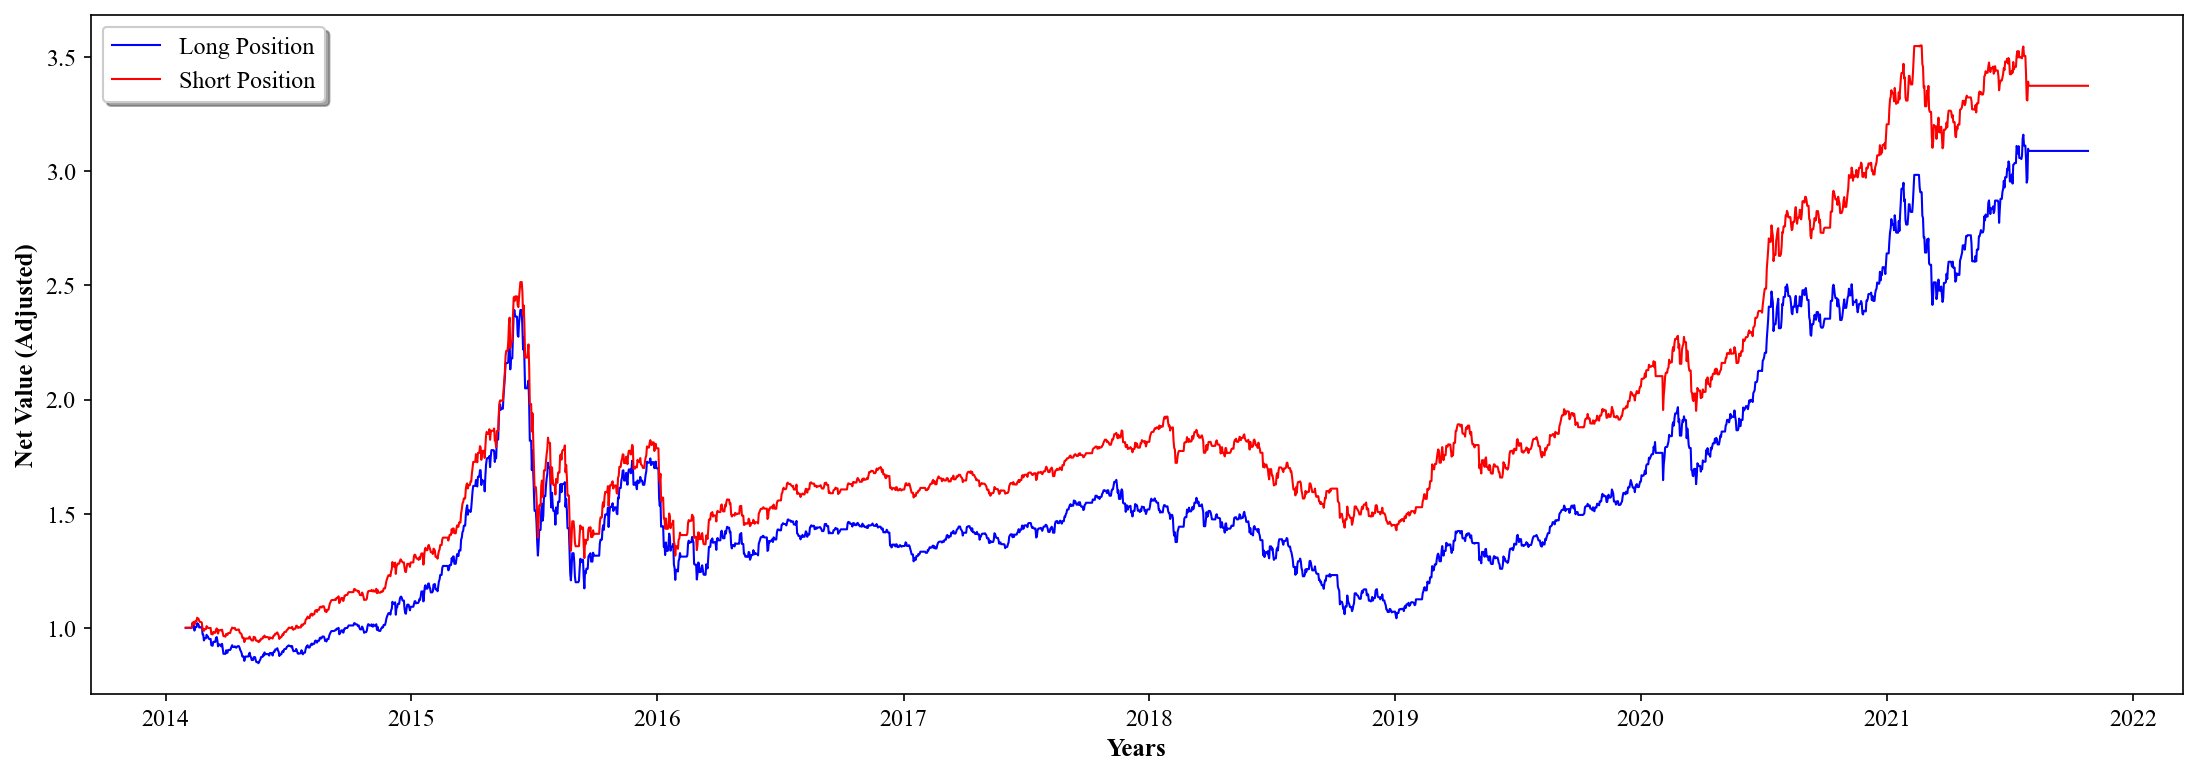

In [37]:
fig = plt.figure(figsize = (18,6),dpi = 150)
ax1 = fig.add_subplot(111)
ax1.plot(np.cumprod((1 + long_daily_returns)), "-",color = "#0000FF",linewidth = 1)#非预测对比序列
ax1.plot(np.cumprod((1 + short_daily_returns)), "-",color = "r",linewidth = 1,)#预测对比序列
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)

plt.legend(["Long Position","Short Position"], loc='upper left',fontsize = 11.5,shadow = True)
ax1.set_ylabel("Net Value (Adjusted)",fontsize = 12,weight = 'bold')
ax1.set_xlabel("Years",fontsize = 12,weight = 'bold')

plt.savefig("./Output/FactorStrategy/Strategy Backtest Plot.png")
# 说明这个因子有反转效应

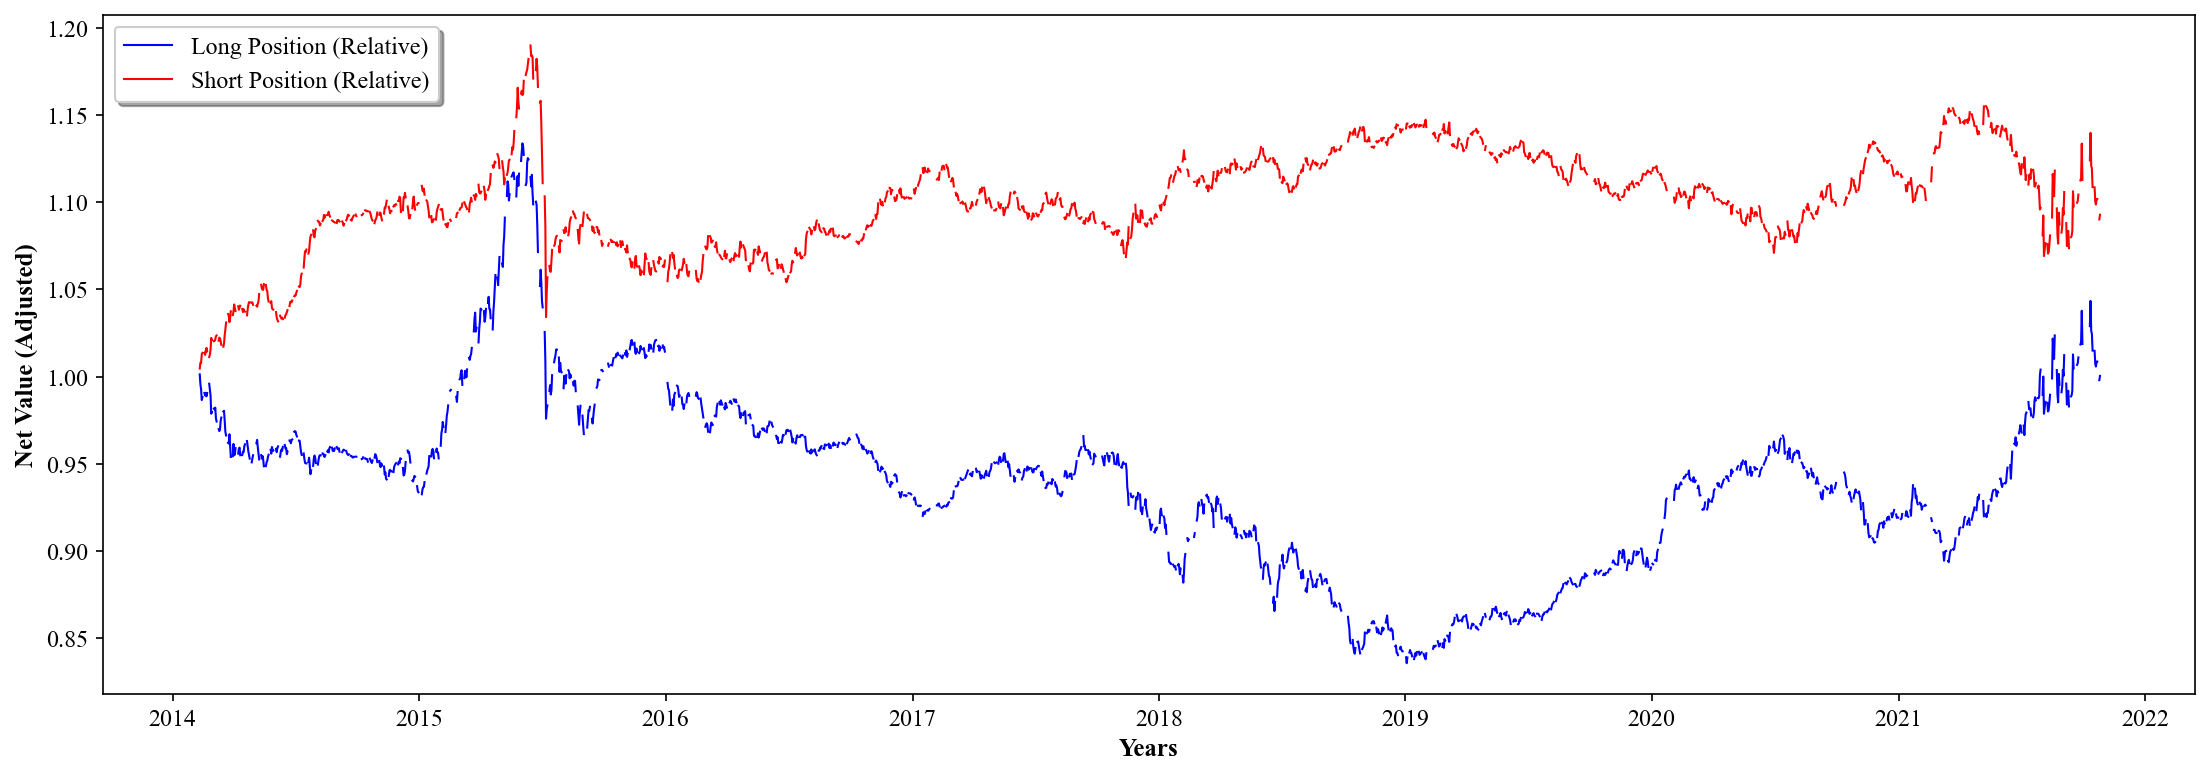

In [38]:
fig = plt.figure(figsize = (18,6),dpi = 150)
ax1 = fig.add_subplot(111)
ax1.plot(np.cumprod((1 + long_daily_returns))/base_NAV.iloc[:,0], "-",color = "#0000FF",linewidth = 1)#非预测对比序列
ax1.plot(np.cumprod((1 + short_daily_returns))/base_NAV.iloc[:,0], "-",color = "r",linewidth = 1,)#预测对比序列
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)

plt.legend(["Long Position (Relative)","Short Position (Relative)"], loc='upper left',fontsize = 11.5,shadow = True)
ax1.set_ylabel("Net Value (Adjusted)",fontsize = 12,weight = 'bold')
ax1.set_xlabel("Years",fontsize = 12,weight = 'bold')

plt.savefig("./Output/FactorStrategy/Strategy Backtest Plot (Relative).png")
# 说明这个因子有反转效应

#### 6.风险收益指标计算

In [39]:
import empyrical

In [40]:
def getRiskReturnIndicator(feat_name,daily_return):
    #计算年化收益率，Sharpe，最大回撤，年化标准差
    #传入的是日历日收益序列，因此annualization设定为365，若为交易日，则为252
    rf = 0.00011741094678452413 # 先设定一个定值，中债10年期国债收益率
    # 1.计算夏普比率
    sharpe = empyrical.sharpe_ratio(daily_return, risk_free = rf, period = 'daily', annualization = 252)
    # 2.计算最大回撤
    max_drawdown = empyrical.max_drawdown(daily_return)
    # 3.计算年化收益率
    annual_return = empyrical.annual_return(daily_return,period = 'daily',annualization = 252)
    # 4.计算年化波动率
    annual_vol = empyrical.annual_volatility(daily_return,period = 'daily',annualization = 252)
    return np.transpose(pd.DataFrame(data = [annual_return,annual_vol,sharpe,max_drawdown],\
                                     index = ["annual_return","annual_vol","sharpe","max_drawdown"],\
                                     columns = [feat_name]))

In [41]:
getRiskReturnIndicator("Long Position",long_daily_returns)

,annual_return,annual_vol,sharpe,max_drawdown
Long Position,0.10581,0.210574,0.443248,-0.564579


In [42]:
getRiskReturnIndicator("Short Position",short_daily_returns)

,annual_return,annual_vol,sharpe,max_drawdown
Short Position,0.114555,0.183148,0.523089,-0.480729
